In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Mogdel 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
INIT_LR=0.0001
EPOCHS=20
BS=32
DIRECTORY=r"E:\Data Science\TCR\Face-Mask-Detection-master\dataset"
CATEGORIES=["with_mask","without_mask"]

In [6]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=0)

In [10]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [11]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 5s 1us/step


In [12]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [13]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [14]:
for layer in baseModel.layers:
	layer.trainable = False

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [16]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
95/95 [==============================] - 437s 5s/step - loss: 0.5422 - acc: 0.7238 - val_loss: 0.4293 - val_acc: 0.8162
Epoch 2/20
95/95 [==============================] - 460s 5s/step - loss: 0.3021 - acc: 0.8764 - val_loss: 0.3130 - val_acc: 0.8644
Epoch 3/20
95/95 [==============================] - 470s 5s/step - loss: 0.2204 - acc: 0.9136 - val_loss: 0.3032 - val_acc: 0.8722
Epoch 4/20
95/95 [==============================] - 473s 5s/step - loss: 0.1980 - acc: 0.9209 - val_loss: 0.3280 - val_acc: 0.8683
Epoch 5/20
95/95 [==============================] - 500s 5s/step - loss: 0.1638 - acc: 0.9400 - val_loss: 0.2434 - val_acc: 0.8970
Epoch 6/20
95/95 [==============================] - 502s 5s/step - loss: 0.1658 - acc: 0.9311 - val_loss: 0.2610 - val_acc: 0.8931
Epoch 7/20
95/95 [==============================] - 491s 5s/step - loss: 0.1444 - acc: 0.9431 - val_loss: 0.1883 - val_a

In [17]:
predIdxs = model.predict(testX, batch_size=BS)

In [18]:
predIdxs = np.argmax(predIdxs, axis=1)

In [19]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.80      0.88       383
without_mask       0.83      0.99      0.90       384

    accuracy                           0.89       767
   macro avg       0.91      0.89      0.89       767
weighted avg       0.91      0.89      0.89       767



In [20]:
model.save("mask_detector.model", save_format="h5")

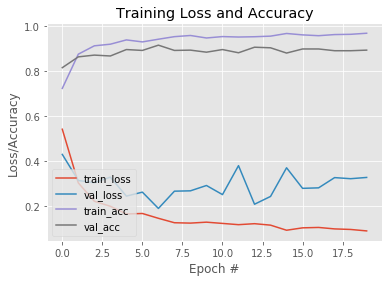

In [23]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")